<a href="https://colab.research.google.com/github/Nirupama-b/GarbageClassification/blob/main/GarbageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [3]:
# Unzip the uploaded file
!unzip # Unzip the uploaded file
!unzip /content/archive (1) 2.zip -d /content


UnZip 6.00 of 20 April 2009, by Debian. Original by Info-ZIP.

Usage: unzip [-Z] [-opts[modifiers]] file[.zip] [list] [-x xlist] [-d exdir]
  Default action is to extract files in list, except those in xlist, to exdir;
  file[.zip] may be a wildcard.  -Z => ZipInfo mode ("unzip -Z" for usage).

  -p  extract files to pipe, no messages     -l  list files (short format)
  -f  freshen existing files, create none    -t  test compressed archive data
  -u  update files, create if necessary      -z  display archive comment only
  -v  list verbosely/show version info       -T  timestamp archive to latest
  -x  exclude files that follow (in xlist)   -d  extract files into exdir
modifiers:
  -n  never overwrite existing files         -q  quiet mode (-qq => quieter)
  -o  overwrite files WITHOUT prompting      -a  auto-convert any text files
  -j  junk paths (do not make directories)   -aa treat ALL files as text
  -U  use escapes for all non-ASCII Unicode  -UU ignore any Unicode fields
  -C  mat

In [ ]:
from google.colab import files

# Upload the dataset zip file from your local Downloads directory
uploaded = files.upload()

In [5]:
import zipfile

# Specify the name of the uploaded zip file
zip_file_name = '/content/archive (1) 2.zip'  # Replace with the actual name of your zip file

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall('/content')



In [6]:
import os

# List the contents of the extracted folder
extracted_folder_path = '/content/archive (1)'  # Replace with the actual path to your extracted folder
contents = os.listdir(extracted_folder_path)

print("Contents of the extracted folder:")
for item in contents:
    print(item)


Contents of the extracted folder:
.DS_Store
Garbage classification


In [7]:
import os
import random
import shutil

# Set the path to your dataset
base_dir = '/content/archive (1)/Garbage classification/Garbage classification'

# Create training and testing directories
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Set the percentage of data for training (80%) and testing (20%)
train_percentage = 0.8

# Iterate through each class folder
classes = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'solar']
for class_name in classes:
    class_dir = os.path.join(base_dir, class_name)

    # Debugging: Print the class directory
    print(f"Class Directory: {class_dir}")

    # Check if the class directory exists
    if not os.path.exists(class_dir):
        print(f"Class directory '{class_name}' not found. Skipping...")
        continue

    images = os.listdir(class_dir)
    random.shuffle(images)

    # Calculate the split index
    split_index = int(train_percentage * len(images))

    # Split the images into training and testing sets
    train_images = images[:split_index]
    test_images = images[split_index:]

    # Create class directories in the training and testing directories
    train_class_dir = os.path.join(train_dir, class_name)
    test_class_dir = os.path.join(test_dir, class_name)

    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(test_class_dir, exist_ok=True)

    # Move images to the respective directories
    for img in train_images:
        src = os.path.join(class_dir, img)
        dst = os.path.join(train_class_dir, img)
        shutil.copyfile(src, dst)

    for img in test_images:
        src = os.path.join(class_dir, img)
        dst = os.path.join(test_class_dir, img)
        shutil.copyfile(src, dst)


Class Directory: /content/archive (1)/Garbage classification/Garbage classification/cardboard
Class Directory: /content/archive (1)/Garbage classification/Garbage classification/glass
Class Directory: /content/archive (1)/Garbage classification/Garbage classification/metal
Class Directory: /content/archive (1)/Garbage classification/Garbage classification/paper
Class Directory: /content/archive (1)/Garbage classification/Garbage classification/plastic
Class Directory: /content/archive (1)/Garbage classification/Garbage classification/solar


In [8]:
IMAGE_SIZE = [224, 224]

In [9]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img

def preprocess_image(img_path, target_size=(224, 224)):
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Rescale to [0, 1]
    return img_array

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data directories
train_data_dir = '/content/archive (1)/Garbage classification/Garbage classification/train'
test_data_dir = '/content/archive (1)/Garbage classification/Garbage classification/test'

# Data augmentation and normalization for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Normalization for testing (without data augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load training dataset
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Load testing dataset
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 2448 images belonging to 6 classes.
Found 615 images belonging to 6 classes.


In [11]:
!pip install efficientnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.1 MB/s eta 0:00:00


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from efficientnet.tfkeras import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import LearningRateScheduler


base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))  # Assuming 6 classes

base_model.trainable = False

# Unfreeze some layers for fine-tuning
for layer in base_model.layers[-20:]:
    layer.trainable = True


model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


16804768/16804768 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 2448 images belonging to 6 classes.
Found 615 images belonging to 6 classes.


In [30]:
from tensorflow.keras.callbacks import ModelCheckpoint


In [31]:
# Assuming 'model' is your trained model
model.save('/content/garbage_classification_model.h5')


In [32]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

In [33]:
# Load the saved model
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

# Define image height and width
image_height = 224  # Replace with the actual height of your images
image_width = 224  # Replace with the actual width of your images


# Create a new model with the desired input layer
input_layer = Input(shape=(image_height, image_width, 3))

In [34]:
# Upload the input image file
uploaded = files.upload()

Saving 20210916_130430_46_11zon_09752f1ad5e74f0db855663e6dd1bfe8.jpg to 20210916_130430_46_11zon_09752f1ad5e74f0db855663e6dd1bfe8 (1).jpg


In [35]:
img_path = next(iter(uploaded))

In [36]:
# Load the input image
img = image.load_img(img_path, target_size=(224, 224))

# Convert the image to a numpy array and preprocess it
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

In [37]:
# Make predictions
predictions = model.predict(img_array)

# Get the predicted class index
predicted_class_index = np.argmax(predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


In [38]:
# Map the class index to the class label
class_labels = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'solar']
predicted_class_label = class_labels[predicted_class_index]

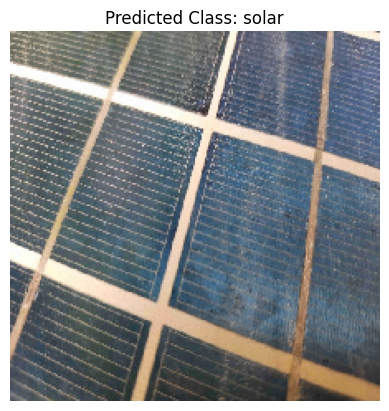

In [39]:
# Display the input image along with the predicted class
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted Class: {predicted_class_label}")
plt.show()